In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Dataset setup

## Load the dataset from .csv file

In [5]:
input_file = "data.csv"
df = pd.read_csv(input_file, header = 0)
df.describe()

,# Liquid Flow Rate (mL/min),Atomization O2 Flow Rate (L/min),Sheath O2 Flow Rate (L/min),ER1 (EtOH/AtomO2),ER2 (EtOH/AtomO2+SheathO2),Burner Cap Temperature,Result
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,8.866792,9.269434,9.767925,0.848491,0.416226,166.018868,1.641509
std,1.633283,1.564203,3.051593,0.170963,0.107188,34.320599,0.653227
min,6.060000,6.180000,5.100000,0.510000,0.230000,130.000000,0.000000
25%,7.500000,8.100000,6.900000,0.760000,0.350000,137.000000,1.000000
50%,8.940000,9.420000,9.900000,0.840000,0.400000,146.000000,2.000000
75%,10.000000,10.500000,12.500000,0.960000,0.490000,203.000000,2.000000
max,11.900000,11.900000,14.900000,1.160000,0.660000,219.000000,2.000000


## Split into input (X) and output (y) variables

In [6]:
dataset = df.values
X = dataset[:,1:7]
y = dataset[:,7]
y = y.astype('int')

# Analyze dataset

## Check if data is skewed
What should my threshold be? I chose to combine Unstable and Maybe

Stable: 73.58490566037736 %
Maybe: 16.9811320754717 %
Unstable: 9.433962264150944 %


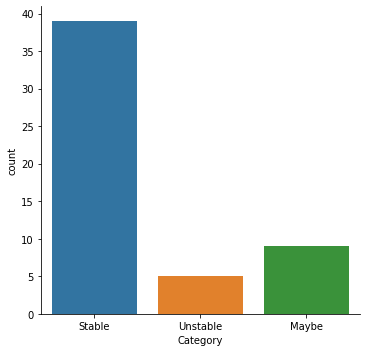

In [7]:
sns.catplot(x="Category", kind="count", data=df)
count = df["Result"].value_counts()
count = count.tolist()
print(f"Stable: {count[0] / len(X) * 100} %")
print(f"Maybe: {count[1] / len(X) * 100} %")
print(f"Unstable: {count[2] / len(X) * 100} %")

## Finding patterns graphically

### Pair plots and histograms of stable vs unstable
What to do with the outlier?

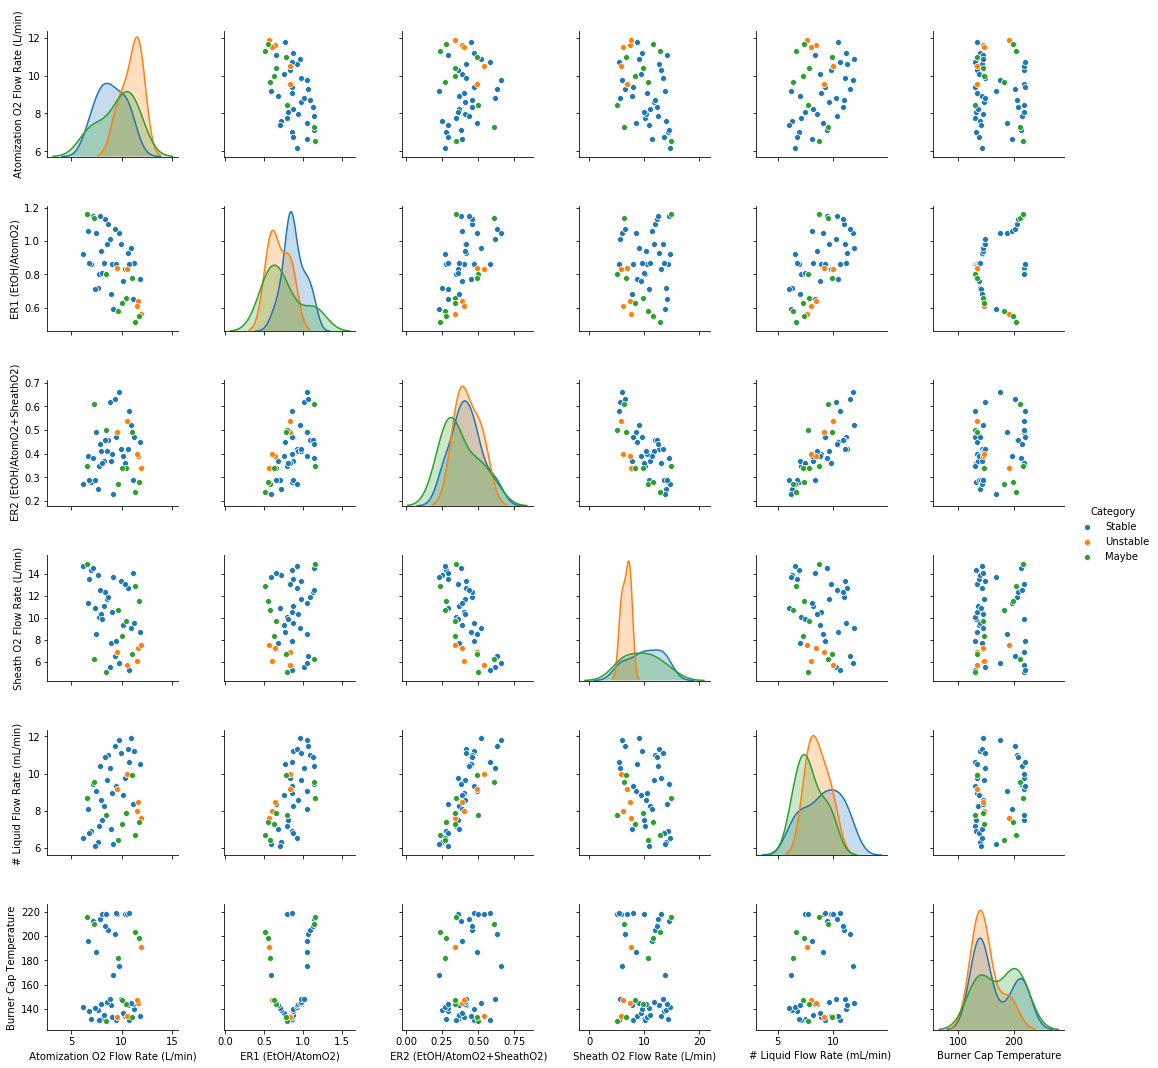

In [8]:
sns.pairplot(df[df.columns.difference(['Result'])], hue='Category')

# Machine Learning

## Prepare data for models

### Standardize the data for ease of use and increased performance
Should I be scaling the only the train and will it affect my model?

In [9]:
scale = StandardScaler().fit(X)
X_std = scale.transform(X)

### Split into train and test set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=.9)

### Leave one out cross validation

In [11]:
loo = LeaveOneOut()
loo.get_n_splits(X_train)

47

## PCA

### 2D

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [13]:
stable = np.array([0.0,0.0])
maybe = np.array([0.0,0.0])
unstable = np.array([0.0,0.0])
for i in range(len(X_pca)):
    if y[i] == 2:
        stable = np.append(stable, X_pca[i])
    elif y[i] == 1:
        maybe = np.append(maybe, X_pca[i])
    else:
        unstable = np.append(unstable, X_pca[i])
stable = stable.reshape((count[0]+1, 2))
maybe = maybe.reshape((count[1]+1, 2))
unstable = unstable.reshape((count[2]+1, 2))

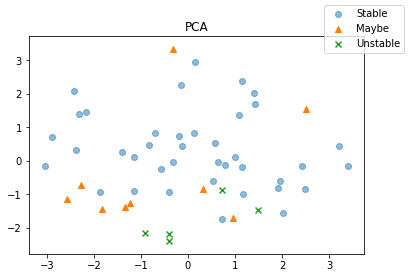

In [14]:
fig, ax = plt.subplots()
ax.scatter(stable[1:, 0], stable[1:, 1], alpha=0.5)
ax.scatter(maybe[1:, 0], maybe[1:, 1], marker="^")
ax.scatter(unstable[1:, 0], unstable[1:, 1], marker="x")
ax.set_title("PCA")
fig.legend(["Stable", "Maybe", "Unstable"])

### 3D

In [15]:
%matplotlib notebook

In [16]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

In [17]:
stable = np.array([0.0,0.0,0.0])
maybe = np.array([0.0,0.0,0.0])
unstable = np.array([0.0,0.0,0.0])
for i in range(len(X_pca)):
    if y[i] == 2:
        stable = np.append(stable, X_pca[i])
    elif y[i] == 1:
        maybe = np.append(maybe, X_pca[i])
    else:
        unstable = np.append(unstable, X_pca[i])
stable = stable.reshape((count[0]+1, 3))
maybe = maybe.reshape((count[1]+1, 3))
unstable = unstable.reshape((count[2]+1, 3))

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stable[1:, 0], stable[1:, 1], stable[1:, 2], alpha=0.5)
ax.scatter(maybe[1:, 0], maybe[1:, 1], maybe[1:, 2], marker="^")
ax.scatter(unstable[1:, 0], unstable[1:, 1], unstable[1:, 2], marker="x")
ax.set_title("PCA")

<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'PCA')

<IPython.core.display.Javascript object>

## Linear

In [19]:
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],'C': [1, 100, 1000]}
log = LogisticRegression(multi_class='auto', max_iter=1000)
clf = GridSearchCV(log, parameters, cv=loo)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'solver': 'liblinear'}
0.8297872340425532


## SVC

In [20]:
parameters = {'kernel': ['rbf', 'linear', 'poly'],'C': [1, 100, 1000]}
svc = SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=loo)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'C': 100, 'kernel': 'rbf'}
0.851063829787234


## KNN

In [21]:
parameters = {'n_neighbors': [2, 3, 4, 5, 6], 'p' : [1, 2]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=loo)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_neighbors': 5, 'p': 2}
0.8085106382978723


## Decision Tree

In [22]:
score = 0
for train_index, cross_index in loo.split(X_train):
    X_train, X_cross = X[train_index], X[cross_index]
    y_train, y_cross = y[train_index], y[cross_index]
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    score += tree.score(X_cross, y_cross)
print(f"Score: {score / 53}")


Score: 0.660377358490566


## Ensemble Methods

### Random Forest

In [23]:
score = 0
for train_index, cross_index in loo.split(X_train):
    X_train, X_cross = X[train_index], X[cross_index]
    y_train, y_cross = y[train_index], y[cross_index]
    forest = RandomForestClassifier(n_estimators=500)
    forest.fit(X_train, y_train)
    score += forest.score(X_cross, y_cross)
print(f"Score: {score / 53}")

Score: 0.6415094339622641


### Ada Boost

In [24]:
score = 0
for train_index, cross_index in loo.split(X_train):
    X_train, X_cross = X[train_index], X[cross_index]
    y_train, y_cross = y[train_index], y[cross_index]
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train, y_train)
    score += ada.score(X_cross, y_cross)
print(f"Score: {score / 53}")


Score: 0.49056603773584906
